# Overview

In this notebook, I conduct the design and development of artificial intelligence models. The main goal of it is to try to predict the physical exercise adherence of the users based on how much time they have been exercising. 

**Author**: Jon Maestre Escobar

**Email**: jonmaestre@opendeusto.es.

In [4]:
import pandas as pd
import numpy as np
import warnings
import pandas as pd
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import time
from utilities import Data_cleaning

from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.express.colors import sample_colorscale

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

import math
import copy
import re
%matplotlib inline

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
df_filtered_merged = pd.read_hdf('../data/filtered_merged_dataset_v1.h5', key='df')
df_filtered_merged.fillna(0, inplace=True)
df_filtered_merged.shape

(46020, 8705)

## **LSTM Model**

In [222]:
from sklearn.model_selection import train_test_split

# Divide el dataset por usuario primero
unique_users = df_filtered_merged['user_programs_user_id'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

# Crear datasets de entrenamiento y prueba basados en usuarios
train_data = df_filtered_merged[df_filtered_merged['user_programs_user_id'].isin(train_users)]
test_data = df_filtered_merged[df_filtered_merged['user_programs_user_id'].isin(test_users)]

# Verifica el número de usuarios únicos en cada conjunto
print(f"Número de usuarios únicos en el conjunto de entrenamiento: {train_data['user_programs_user_id'].nunique()}")
print(f"Número de usuarios únicos en el conjunto de prueba: {test_data['user_programs_user_id'].nunique()}")

Número de usuarios únicos en el conjunto de entrenamiento: 2550
Número de usuarios únicos en el conjunto de prueba: 638


In [223]:
from sklearn.preprocessing import MinMaxScaler

# Agregación y normalización para el conjunto de entrenamiento
aggregated_train = train_data.groupby('user_programs_user_id').agg({
    'sum_of_reps': 'sum',
    'sum_of_time': 'sum',
    'total_count_of_series_reps': 'sum',
    'total_count_of_series_time': 'sum',
    'date': 'count'
}).reset_index()

aggregated_train = aggregated_train.rename(columns={'date': 'total_training_days'})

features_train = aggregated_train[['sum_of_reps', 'sum_of_time', 'total_count_of_series_reps',
                                   'total_count_of_series_time', 'total_training_days']].values
user_ids_train = aggregated_train['user_programs_user_id'].values

scaler = MinMaxScaler()
scaled_features_train = scaler.fit_transform(features_train)

# Agregación y normalización para el conjunto de prueba
aggregated_test = test_data.groupby('user_programs_user_id').agg({
    'sum_of_reps': 'sum',
    'sum_of_time': 'sum',
    'total_count_of_series_reps': 'sum',
    'total_count_of_series_time': 'sum',
    'date': 'count'
}).reset_index()

aggregated_test = aggregated_test.rename(columns={'date': 'total_training_days'})

features_test = aggregated_test[['sum_of_reps', 'sum_of_time', 'total_count_of_series_reps',
                                 'total_count_of_series_time', 'total_training_days']].values
user_ids_test = aggregated_test['user_programs_user_id'].values

scaled_features_test = scaler.transform(features_test)

Shape of X_train: (2550, 1, 5)
Shape of y_train: (2550,)
Shape of X_test: (638, 1, 5)
Shape of y_test: (638,)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 1, 50)          │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0047 - val_loss: 2.2329e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6783e-04 - val_loss: 2.9999e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6126e-04 - val_loss: 1.8254e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0882e-04 - val_loss: 2.1395e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0614e-04 - val_loss: 1.6103e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0293e-04 - val_loss: 1.4067e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4894e-04 - val_loss: 1.2024e-04
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7857e-04 - val_loss: 1.0494e-04
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8554e-04 - val_loss: 1.9073e-04
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8090e-04 - val_loss: 7.6623e-05
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1195e-04 - val_loss: 1

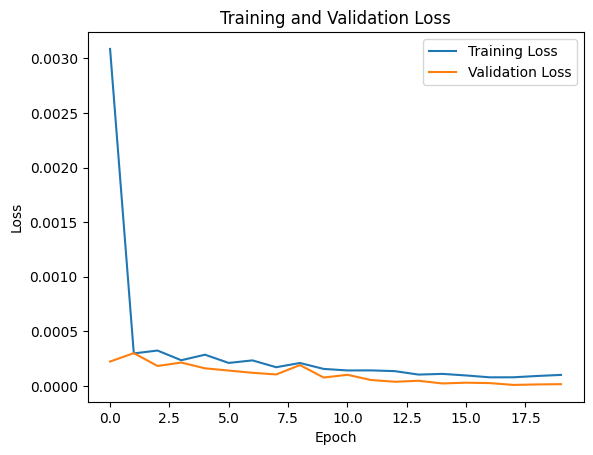

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MSE: 1.5955963858682262e-05
MAPE: 234.47674971506441


In [228]:
# Crear secuencias con IDs de usuario
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length - 1, 1])  # Usando 'sum_of_time' como objetivo
    return np.array(X), np.array(y)

# Dado que estamos agregando datos, el seq_length será 1 (un solo punto de datos por usuario)
seq_length = 1  # No crearemos secuencias a lo largo del tiempo en este caso

# Crear secuencias de entrenamiento y prueba
X_train, y_train = create_sequences(scaled_features_train, seq_length)
X_test, y_test = create_sequences(scaled_features_test, seq_length)

# Asegúrate de que las dimensiones sean correctas
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Redimensionar las características para adaptarlas al modelo LSTM (agregando la dimensión de tiempo)
X_train = X_train.reshape((X_train.shape[0], seq_length, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], seq_length, X_test.shape[2]))

# Ahora, entrenar el modelo LSTM
model = Sequential()

# Añadir la primera capa LSTM con regularización Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Añadir una segunda capa LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Añadir la capa de salida
model.add(Dense(units=1))  # Prediciendo 'sum_of_time' como proxy para la adherencia

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Mostrar el resumen del modelo
model.summary()

# Entrenar el modelo LSTM
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular MSE y MAPE
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'MSE: {mse}')
print(f'MAPE: {mape}')


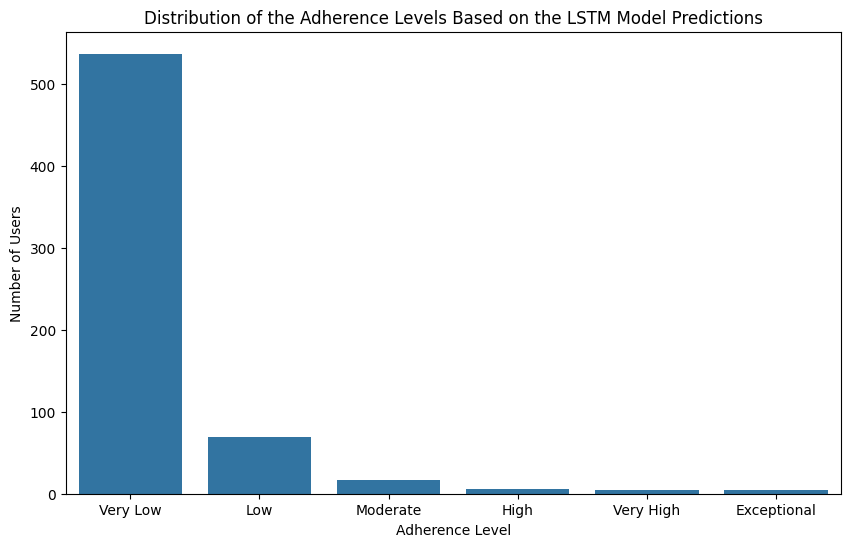

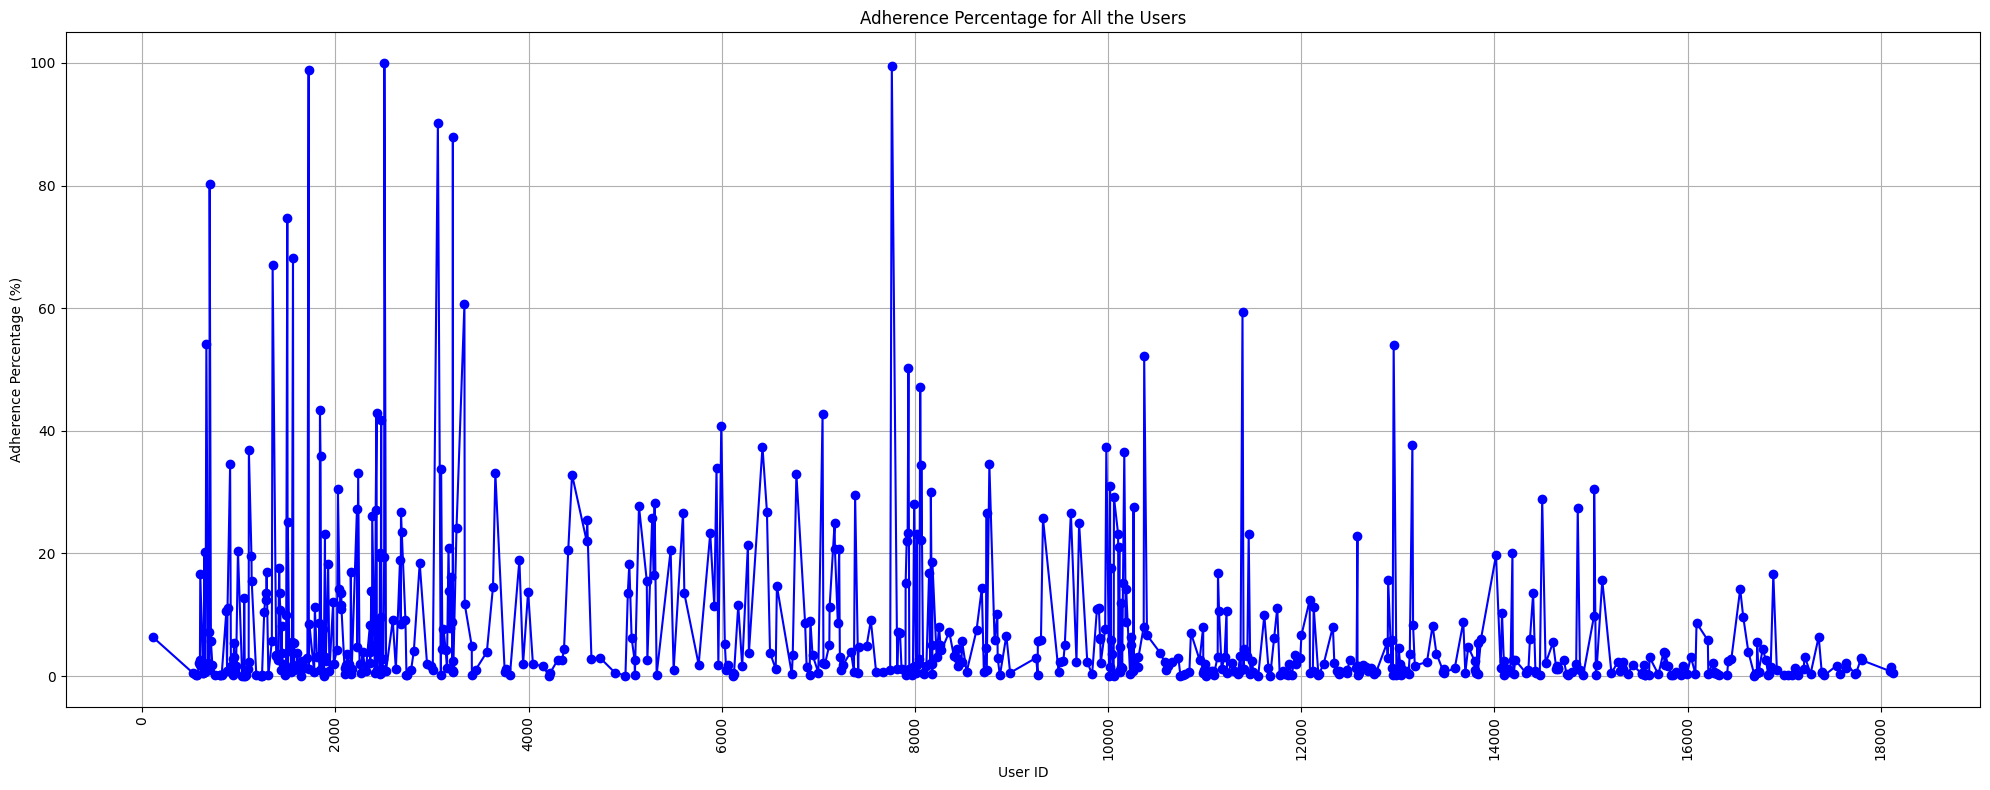

Top 10 users with higher adherence based on LSTM Model Predictions:
     user_id  Adherence_Score Adherence_Level  Adherence_Percentage
157     2507         1.000000     Exceptional            100.000000
289     7761         0.994866     Exceptional             99.486565
91      1723         0.988960     Exceptional             98.895973
174     3061         0.902319     Exceptional             90.231895
188     3216         0.879859     Exceptional             87.985947
19       698         0.803390       Very High             80.339005
74      1502         0.746957       Very High             74.695732
81      1561         0.681166       Very High             68.116600
59      1350         0.671176       Very High             67.117615
192     3336         0.607060            High             60.705994


In [310]:
# Normalizar las predicciones para obtener puntuaciones de adherencia entre 0 y 1
min_pred = y_pred.min()
max_pred = y_pred.max()

adherence_scores = (y_pred - min_pred) / (max_pred - min_pred)

# Definir umbrales para 6 niveles de adherencia
thresholds = np.linspace(0, 1, 7)  # 7 valores espaciados uniformemente para 6 niveles

# Asignar niveles de adherencia en función de los umbrales
adherence_levels = []
for score in adherence_scores:
    if score <= thresholds[1]:
        adherence_levels.append('Very Low')
    elif score <= thresholds[2]:
        adherence_levels.append('Low')
    elif score <= thresholds[3]:
        adherence_levels.append('Moderate')
    elif score <= thresholds[4]:
        adherence_levels.append('High')
    elif score <= thresholds[5]:
        adherence_levels.append('Very High')
    else:
        adherence_levels.append('Exceptional')

# Añadir niveles de adherencia y puntuaciones al DataFrame
adherence_df = pd.DataFrame({
    'user_id': user_ids_test.flatten(),
    'Predicted_Sum_of_Time': y_pred.flatten(),
    'Adherence_Score': adherence_scores.flatten(),
    'Adherence_Level': adherence_levels
})

# Ahora, agrupar los niveles de adherencia por usuario
user_adherence_df = adherence_df.groupby('user_id').agg({
    'Adherence_Score': 'mean',
    'Adherence_Level': lambda x: x.mode()[0]  # Selecciona el nivel de adherencia más frecuente
}).reset_index()

# Añadir un porcentaje de adherencia basado en la puntuación promedio de adherencia
user_adherence_df['Adherence_Percentage'] = user_adherence_df['Adherence_Score'] * 100

# Visualizar la distribución de los niveles de adherencia
plt.figure(figsize=(10, 6))
sns.countplot(x='Adherence_Level', data=user_adherence_df, order=['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Exceptional'])
plt.title('Distribution of the Adherence Levels Based on the LSTM Model Predictions')
plt.xlabel('Adherence Level')
plt.ylabel('Number of Users')
plt.show()

# Visualizar la adherencia de cada usuario en un gráfico de líneas
plt.figure(figsize=(20, 8))
plt.plot(user_adherence_df['user_id'], user_adherence_df['Adherence_Percentage'], marker='o', linestyle='-', color='b')
plt.title('Adherence Percentage for All the Users')
plt.xlabel('User ID')
plt.ylabel('Adherence Percentage (%)')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x si hay muchos usuarios
plt.grid(True)

# Opcional: limitar el número de marcas en el eje x si el gráfico está muy cargado
plt.locator_params(axis='x', nbins=10)  # Ajustar el número de marcas en el eje x

plt.tight_layout()
plt.show()

# Mostrar una tabla con los 10 usuarios con mayor adherencia
top_adherence_users_lstm = user_adherence_df.sort_values(by='Adherence_Percentage', ascending=False).head(10)
print("Top 10 users with higher adherence based on LSTM Model Predictions:")
print(top_adherence_users_lstm)

In [311]:
user_adherence_df

,user_id,Adherence_Score,Adherence_Level,Adherence_Percentage
0,108,0.063804,Very Low,6.380395
1,526,0.004877,Very Low,0.487715
2,542,0.003850,Very Low,0.385050
3,557,0.001090,Very Low,0.109047
4,571,0.001399,Very Low,0.139943
...,...,...,...,...
633,17798,0.029410,Very Low,2.941001
634,17810,0.025559,Very Low,2.555854
635,18096,0.008088,Very Low,0.808773
636,18108,0.014636,Very Low,1.463629


Adherence_Level
Very Low       2377
Low             145
Moderate         24
Exceptional       2
High              2
Name: count, dtype: int64


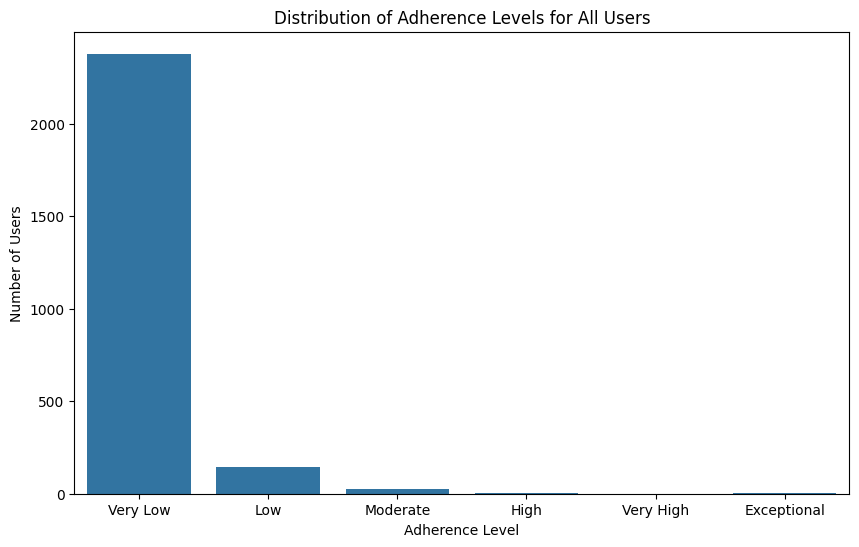

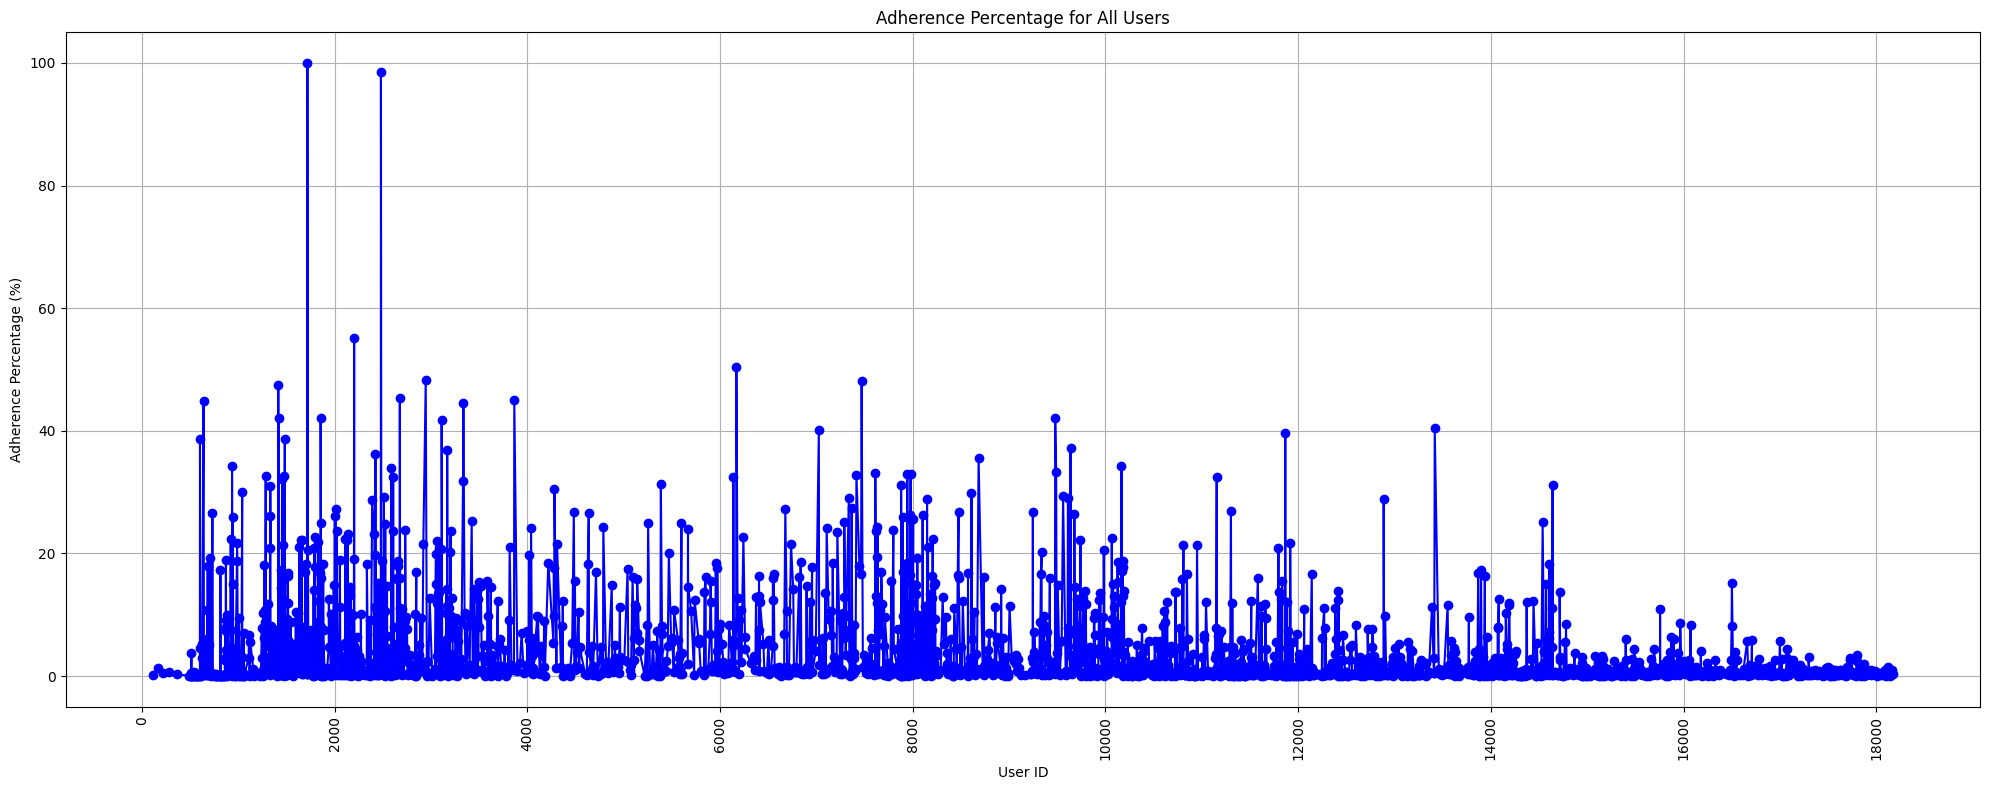

Top 10 users with higher adherence based on LSTM Model Predictions:
     user_id  Adherence_Score Adherence_Level  Adherence_Percentage
157     2507         1.000000     Exceptional            100.000000
289     7761         0.994866     Exceptional             99.486565
91      1723         0.988960     Exceptional             98.895973
174     3061         0.902319     Exceptional             90.231895
188     3216         0.879859     Exceptional             87.985947
19       698         0.803390       Very High             80.339005
74      1502         0.746957       Very High             74.695732
81      1561         0.681166       Very High             68.116600
59      1350         0.671176       Very High             67.117615
192     3336         0.607060            High             60.705994


In [312]:
# Primero, volvamos a escalar todos los datos utilizando el mismo scaler que usamos para el entrenamiento
scaled_features_all = scaler.transform(features_train)  # Utilizando el scaler ajustado en los datos de entrenamiento

# Calcular las puntuaciones de adherencia para todo el dataset
min_time = scaled_features_all[:, 1].min()
max_time = scaled_features_all[:, 1].max()

adherence_scores_all = (scaled_features_all[:, 1] - min_time) / (max_time - min_time)  # Normalizando la adherencia

# Crear niveles de adherencia basados en los umbrales definidos
thresholds = np.linspace(0, 1, 7)  # 6 niveles de adherencia

adherence_levels_all = []

for score in adherence_scores_all:
    if score <= thresholds[1]:
        adherence_levels_all.append('Very Low')
    elif score <= thresholds[2]:
        adherence_levels_all.append('Low')
    elif score <= thresholds[3]:
        adherence_levels_all.append('Moderate')
    elif score <= thresholds[4]:
        adherence_levels_all.append('High')
    elif score <= thresholds[5]:
        adherence_levels_all.append('Very High')
    else:
        adherence_levels_all.append('Exceptional')

# Crear el DataFrame de adherencia
adherence_df_all = pd.DataFrame({
    'user_id': user_ids_train,
    'Adherence_Score': adherence_scores_all,
    'Adherence_Level': adherence_levels_all
})

# Contar el número de usuarios en cada nivel de adherencia
adherence_distribution_all = adherence_df_all['Adherence_Level'].value_counts()
print(adherence_distribution_all)

# Visualizar la distribución de niveles de adherencia
plt.figure(figsize=(10, 6))
sns.countplot(x='Adherence_Level', data=adherence_df_all, order=['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Exceptional'])
plt.title('Distribution of Adherence Levels for All Users')
plt.xlabel('Adherence Level')
plt.ylabel('Number of Users')
plt.show()

# Convertir las puntuaciones de adherencia a porcentajes
adherence_df_all['Adherence_Percentage'] = adherence_df_all['Adherence_Score'] * 100

# Ordenar el DataFrame por user_id
adherence_df_all = adherence_df_all.sort_values(by='user_id')

# Graficar el porcentaje de adherencia por usuario
plt.figure(figsize=(20, 8))
plt.plot(adherence_df_all['user_id'], adherence_df_all['Adherence_Percentage'], marker='o', linestyle='-', color='b')
plt.title('Adherence Percentage for All Users')
plt.xlabel('User ID')
plt.ylabel('Adherence Percentage (%)')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x si hay muchos usuarios
plt.grid(True)

# Opcional: limitar el número de ticks en el eje x si el gráfico está muy cargado
plt.locator_params(axis='x', nbins=10)  # Ajustar el número de ticks en el eje x

plt.tight_layout()
plt.show()

# Mostrar una tabla con los 10 usuarios con mayor adherencia
top_adherence_users_lstm = user_adherence_df.sort_values(by='Adherence_Percentage', ascending=False).head(10)
print("Top 10 users with higher adherence based on LSTM Model Predictions:")
print(top_adherence_users_lstm)

In [313]:
# Verifica los primeros 10 IDs en top_adherence_users
print("User IDs en top_adherence_users:")
print(top_adherence_users_lstm['user_id'].values)

# Verifica si estos IDs están presentes en df_filtered_merged
print("Coincidencia de IDs en df_filtered_merged:")
print(df_filtered_merged['user_programs_user_id'].isin(top_adherence_users_lstm['user_id']).sum())

# Filtra df_filtered_merged para obtener solo las filas que coinciden con los IDs en top_adherence_users
filtered_df = df_filtered_merged[df_filtered_merged['user_programs_user_id'].isin(top_adherence_users_lstm['user_id'])]

# Verifica si hay datos después de filtrar
print("Número de filas en filtered_df después del filtrado:", len(filtered_df))

# Si hay filas coincidentes, procede con el merge
if len(filtered_df) > 0:
    selected_columns = filtered_df[['user_programs_user_id', 'sum_of_reps', 'sum_of_time', 'total_count_of_series_reps', 
                                    'total_count_of_series_time', 'total_training_days']]

    # Agrupar por 'user_programs_user_id' para sumar las columnas específicas
    selected_columns = selected_columns.groupby('user_programs_user_id').agg({
        'sum_of_reps': 'sum',
        'sum_of_time': 'sum',
        'total_count_of_series_reps': 'sum',
        'total_count_of_series_time': 'sum',
        'total_training_days': 'first'  # Mantén el primer valor para esta columna
    }).reset_index()

    # Renombra columnas en selected_columns para evitar conflictos durante el merge
    selected_columns = selected_columns.rename(columns={
        'sum_of_reps': 'sum_of_reps_merged',
        'sum_of_time': 'sum_of_time_merged',
        'total_count_of_series_reps': 'total_count_of_series_reps_merged',
        'total_count_of_series_time': 'total_count_of_series_time_merged',
        'total_training_days': 'total_training_days_merged'
    })

    # Elimina la columna 'user_programs_user_id' duplicada antes del merge
    top_adherence_users_lstm = top_adherence_users_lstm.drop(columns=['user_programs_user_id'], errors='ignore')

    # Realiza el merge con top_adherence_users usando 'user_id' y 'user_programs_user_id'
    merged_df = pd.merge(top_adherence_users_lstm, selected_columns, 
                         left_on='user_id', right_on='user_programs_user_id', 
                         how='left')

    # Selecciona y reorganiza las columnas que deseas mostrar
    final_df_lstm = merged_df[['user_id', 'Adherence_Score', 'Adherence_Level', 'Adherence_Percentage',
                          'sum_of_reps_merged', 'sum_of_time_merged', 'total_count_of_series_reps_merged', 
                          'total_count_of_series_time_merged', 'total_training_days_merged']]

    # Muestra la tabla resultante
    print("Top 10 users with higher adherence and their training details:")
    print(final_df_lstm.head())
else:
    print("No hay coincidencias entre los IDs de top_adherence_users y df_filtered_merged.")


User IDs en top_adherence_users:
[2507 7761 1723 3061 3216  698 1502 1561 1350 3336]
Coincidencia de IDs en df_filtered_merged:
1243
Número de filas en filtered_df después del filtrado: 1243
Top 10 users with higher adherence and their training details:
   user_id  Adherence_Score Adherence_Level  Adherence_Percentage  \
0     2507         1.000000     Exceptional            100.000000   
1     7761         0.994866     Exceptional             99.486565   
2     1723         0.988960     Exceptional             98.895973   
3     3061         0.902319     Exceptional             90.231895   
4     3216         0.879859     Exceptional             87.985947   

   sum_of_reps_merged  sum_of_time_merged  total_count_of_series_reps_merged  \
0             53260.0            245944.0                               4103   
1             34943.0            240704.0                               4336   
2             59135.0            236264.0                               5079   
3          

In [314]:
final_df_lstm

,user_id,Adherence_Score,Adherence_Level,Adherence_Percentage,sum_of_reps_merged,sum_of_time_merged,total_count_of_series_reps_merged,total_count_of_series_time_merged,total_training_days_merged
0,2507,1.000000,Exceptional,100.000000,53260.0,245944.0,4103,6094,132
1,7761,0.994866,Exceptional,99.486565,34943.0,240704.0,4336,7019,123
2,1723,0.988960,Exceptional,98.895973,59135.0,236264.0,5079,7298,181
3,3061,0.902319,Exceptional,90.231895,40227.0,227245.0,2718,3610,74
4,3216,0.879859,Exceptional,87.985947,51601.0,207615.0,5170,8152,161
5,698,0.803390,Very High,80.339005,62745.0,194194.0,4294,5951,137
6,1502,0.746957,Very High,74.695732,50906.0,178733.0,4251,6284,116
7,1561,0.681166,Very High,68.116600,21596.0,165503.0,2917,4843,74
8,1350,0.671176,Very High,67.117615,23990.0,163573.0,2466,3841,103
9,3336,0.607060,High,60.705994,36834.0,143262.0,3122,4506,142


A partir de las imágenes y los datos, se pueden sacar algunas conclusiones sobre los factores que parecen influir en la predicción de la adherencia al ejercicio físico.

**Observaciones Clave:**

1. **Sum of Reps y Sum of Time**: Los usuarios con mayores valores en estas métricas, como el usuario 2507 y 1723, tienden a tener una alta adherencia. Es evidente que la cantidad total de repeticiones y el tiempo total de entrenamiento son factores importantes en la evaluación de la adherencia. Sin embargo, el usuario 1723 tiene más tiempo total de entrenamiento y más repeticiones totales que el usuario 2507, pero aún así, tiene una adherencia ligeramente menor (98.04% vs 100%). Esto sugiere que, aunque estos factores son importantes, no son los únicos determinantes.

2. **Total Count of Series Reps y Time**: Estas métricas también son significativas. Los usuarios con un mayor número de series totales de repeticiones y tiempo, como el usuario 1723, tienden a mostrar alta adherencia. Sin embargo, el usuario 2507 tiene un menor número de series en comparación con el usuario 1723, pero sigue siendo el que tiene mayor adherencia.

3. **Total Training Days**: El número de días de entrenamiento parece ser un factor crítico. Los usuarios con más días de entrenamiento, como el usuario 1723 (181 días) y 3216 (161 días), tienden a tener alta adherencia. Sin embargo, no es el único factor determinante, ya que el usuario 2507, con menos días de entrenamiento (132 días), aún tiene la mayor adherencia.

**Conclusión:**

La adherencia parece estar influenciada por una combinación de factores, donde la suma de repeticiones, el tiempo total de entrenamiento, el número total de series y los días de entrenamiento juegan un papel importante. Sin embargo, no hay un único factor que determine completamente la adherencia. Por ejemplo, aunque el usuario 1723 tiene más días de entrenamiento, series y tiempo total que el usuario 2507, este último tiene una mayor adherencia. Esto sugiere que puede haber otros factores no considerados en los datos o que la relación entre estos factores y la adherencia no es lineal, y podría depender también de cómo estos factores interactúan entre sí.

Finalmente, el algoritmo parece dar más peso a la suma total de repeticiones y tiempo, junto con el número de series, pero otros factores o interacciones entre estos pueden influir en el resultado final de adherencia.

---
---
---
---
---
---
---
---

## **GRU Model**

In [306]:
from sklearn.model_selection import train_test_split

# Divide el dataset por usuario primero
unique_users = df_filtered_merged['user_programs_user_id'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

# Crear datasets de entrenamiento y prueba basados en usuarios
train_data = df_filtered_merged[df_filtered_merged['user_programs_user_id'].isin(train_users)]
test_data = df_filtered_merged[df_filtered_merged['user_programs_user_id'].isin(test_users)]

# Verifica el número de usuarios únicos en cada conjunto
print(f"Número de usuarios únicos en el conjunto de entrenamiento: {train_data['user_programs_user_id'].nunique()}")
print(f"Número de usuarios únicos en el conjunto de prueba: {test_data['user_programs_user_id'].nunique()}")

Número de usuarios únicos en el conjunto de entrenamiento: 2550
Número de usuarios únicos en el conjunto de prueba: 638


In [307]:
from sklearn.preprocessing import MinMaxScaler

# Agregación y normalización para el conjunto de entrenamiento
aggregated_train = train_data.groupby('user_programs_user_id').agg({
    'sum_of_reps': 'sum',
    'sum_of_time': 'sum',
    'total_count_of_series_reps': 'sum',
    'total_count_of_series_time': 'sum',
    'date': 'count'
}).reset_index()

aggregated_train = aggregated_train.rename(columns={'date': 'total_training_days'})

features_train = aggregated_train[['sum_of_reps', 'sum_of_time', 'total_count_of_series_reps',
                                   'total_count_of_series_time', 'total_training_days']].values
user_ids_train = aggregated_train['user_programs_user_id'].values

scaler = MinMaxScaler()
scaled_features_train = scaler.fit_transform(features_train)

# Agregación y normalización para el conjunto de prueba
aggregated_test = test_data.groupby('user_programs_user_id').agg({
    'sum_of_reps': 'sum',
    'sum_of_time': 'sum',
    'total_count_of_series_reps': 'sum',
    'total_count_of_series_time': 'sum',
    'date': 'count'
}).reset_index()

aggregated_test = aggregated_test.rename(columns={'date': 'total_training_days'})

features_test = aggregated_test[['sum_of_reps', 'sum_of_time', 'total_count_of_series_reps',
                                 'total_count_of_series_time', 'total_training_days']].values
user_ids_test = aggregated_test['user_programs_user_id'].values

scaled_features_test = scaler.transform(features_test)

Shape of X_train: (2550, 1, 5)
Shape of y_train: (2550,)
Shape of X_test: (638, 1, 5)
Shape of y_test: (638,)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_18 (GRU)                    │ (None, 1, 50)          │         8,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_19 (GRU)                    │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,901 (93.36 KB)

 Trainable params: 23,901 (93.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0025 - val_loss: 2.0971e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9060e-04 - val_loss: 1.5602e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1430e-04 - val_loss: 1.4080e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9772e-04 - val_loss: 1.0467e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6610e-04 - val_loss: 7.6486e-05
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2476e-04 - val_loss: 7.6867e-05
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2244e-04 - val_loss: 5.6238e-05
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2959e-04 - val_loss: 2.6865e-05
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2951e-04 - val_loss: 2.0700e-05
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2644e-04 - val_loss: 1.1661e-05
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2025e-04 - val_loss: 3

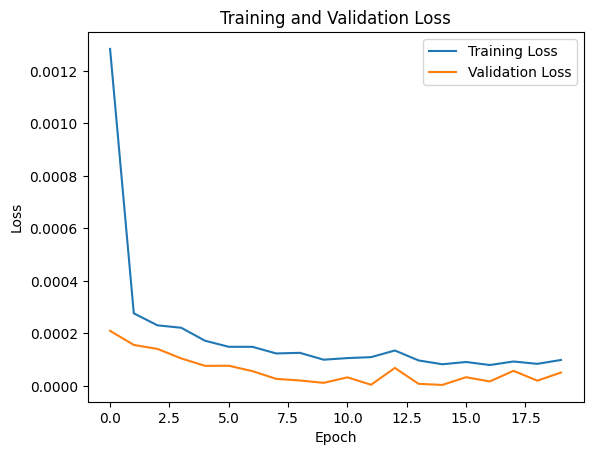

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE: 5.086145194500994e-05
MAPE: 445.12099770805696


In [309]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Crear secuencias con IDs de usuario
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length - 1, 1])  # Usando 'sum_of_time' como objetivo
    return np.array(X), np.array(y)

# Dado que estamos agregando datos, el seq_length será 1 (un solo punto de datos por usuario)
seq_length = 1  # No crearemos secuencias a lo largo del tiempo en este caso

# Crear secuencias de entrenamiento y prueba
X_train, y_train = create_sequences(scaled_features_train, seq_length)
X_test, y_test = create_sequences(scaled_features_test, seq_length)

# Asegúrate de que las dimensiones sean correctas
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Redimensionar las características para adaptarlas al modelo GRU (agregando la dimensión de tiempo)
X_train = X_train.reshape((X_train.shape[0], seq_length, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], seq_length, X_test.shape[2]))

# Ahora, entrenar el modelo GRU
model = Sequential()

# Añadir la primera capa GRU con regularización Dropout
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Añadir una segunda capa GRU
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Añadir la capa de salida
model.add(Dense(units=1))  # Prediciendo 'sum_of_time' como proxy para la adherencia

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Mostrar el resumen del modelo
model.summary()

# Entrenar el modelo GRU
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular MSE y MAPE
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'MSE: {mse}')
print(f'MAPE: {mape}')


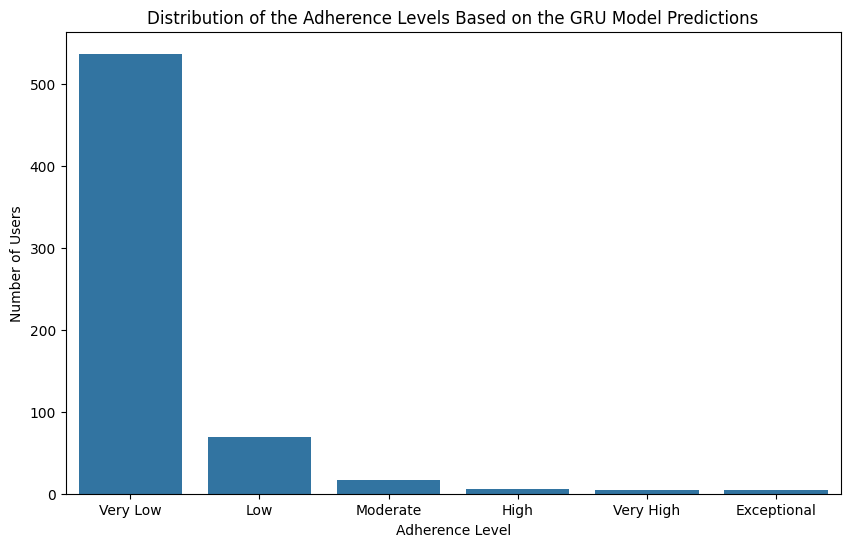

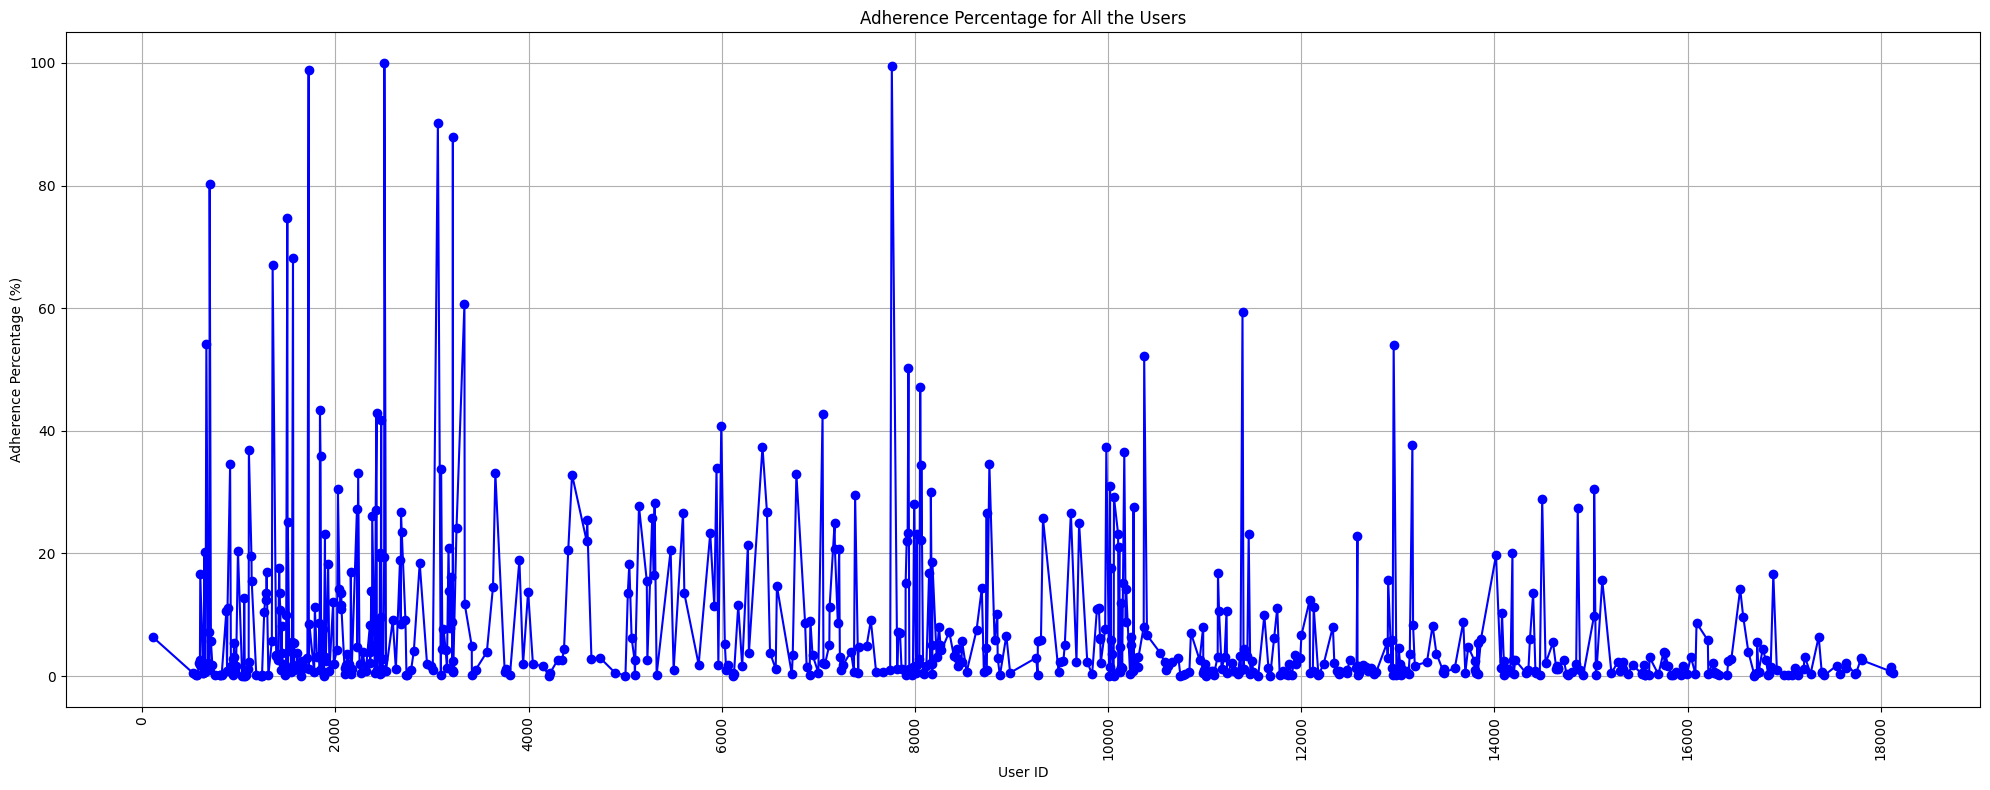

Top 10 users with higher adherence based on GRU Model Predictions:
     user_id  Adherence_Score Adherence_Level  Adherence_Percentage
157     2507         1.000000     Exceptional            100.000000
289     7761         0.994866     Exceptional             99.486565
91      1723         0.988960     Exceptional             98.895973
174     3061         0.902319     Exceptional             90.231895
188     3216         0.879859     Exceptional             87.985947
19       698         0.803390       Very High             80.339005
74      1502         0.746957       Very High             74.695732
81      1561         0.681166       Very High             68.116600
59      1350         0.671176       Very High             67.117615
192     3336         0.607060            High             60.705994


In [315]:
# Normalizar las predicciones para obtener puntuaciones de adherencia entre 0 y 1
min_pred = y_pred.min()
max_pred = y_pred.max()

adherence_scores = (y_pred - min_pred) / (max_pred - min_pred)

# Definir umbrales para 6 niveles de adherencia
thresholds = np.linspace(0, 1, 7)  # 7 valores espaciados uniformemente para 6 niveles

# Asignar niveles de adherencia en función de los umbrales
adherence_levels = []
for score in adherence_scores:
    if score <= thresholds[1]:
        adherence_levels.append('Very Low')
    elif score <= thresholds[2]:
        adherence_levels.append('Low')
    elif score <= thresholds[3]:
        adherence_levels.append('Moderate')
    elif score <= thresholds[4]:
        adherence_levels.append('High')
    elif score <= thresholds[5]:
        adherence_levels.append('Very High')
    else:
        adherence_levels.append('Exceptional')

# Añadir niveles de adherencia y puntuaciones al DataFrame
adherence_df = pd.DataFrame({
    'user_id': user_ids_test.flatten(),
    'Predicted_Sum_of_Time': y_pred.flatten(),
    'Adherence_Score': adherence_scores.flatten(),
    'Adherence_Level': adherence_levels
})

# Ahora, agrupar los niveles de adherencia por usuario
user_adherence_df = adherence_df.groupby('user_id').agg({
    'Adherence_Score': 'mean',
    'Adherence_Level': lambda x: x.mode()[0]  # Selecciona el nivel de adherencia más frecuente
}).reset_index()

# Añadir un porcentaje de adherencia basado en la puntuación promedio de adherencia
user_adherence_df['Adherence_Percentage'] = user_adherence_df['Adherence_Score'] * 100

# Visualizar la distribución de los niveles de adherencia
plt.figure(figsize=(10, 6))
sns.countplot(x='Adherence_Level', data=user_adherence_df, order=['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Exceptional'])
plt.title('Distribution of the Adherence Levels Based on the GRU Model Predictions')
plt.xlabel('Adherence Level')
plt.ylabel('Number of Users')
plt.show()

# Visualizar la adherencia de cada usuario en un gráfico de líneas
plt.figure(figsize=(20, 8))
plt.plot(user_adherence_df['user_id'], user_adherence_df['Adherence_Percentage'], marker='o', linestyle='-', color='b')
plt.title('Adherence Percentage for All the Users')
plt.xlabel('User ID')
plt.ylabel('Adherence Percentage (%)')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x si hay muchos usuarios
plt.grid(True)

# Opcional: limitar el número de marcas en el eje x si el gráfico está muy cargado
plt.locator_params(axis='x', nbins=10)  # Ajustar el número de marcas en el eje x

plt.tight_layout()
plt.show()

# Mostrar una tabla con los 10 usuarios con mayor adherencia
top_adherence_users_gru = user_adherence_df.sort_values(by='Adherence_Percentage', ascending=False).head(10)
print("Top 10 users with higher adherence based on GRU Model Predictions:")
print(top_adherence_users_gru)

In [316]:
user_adherence_df

,user_id,Adherence_Score,Adherence_Level,Adherence_Percentage
0,108,0.063804,Very Low,6.380395
1,526,0.004877,Very Low,0.487715
2,542,0.003850,Very Low,0.385050
3,557,0.001090,Very Low,0.109047
4,571,0.001399,Very Low,0.139943
...,...,...,...,...
633,17798,0.029410,Very Low,2.941001
634,17810,0.025559,Very Low,2.555854
635,18096,0.008088,Very Low,0.808773
636,18108,0.014636,Very Low,1.463629


Adherence_Level
Very Low       2377
Low             145
Moderate         24
Exceptional       2
High              2
Name: count, dtype: int64


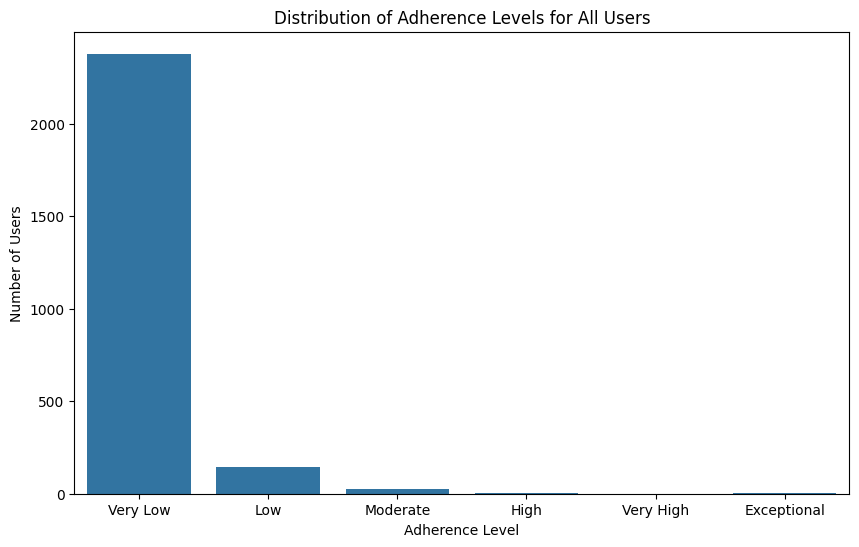

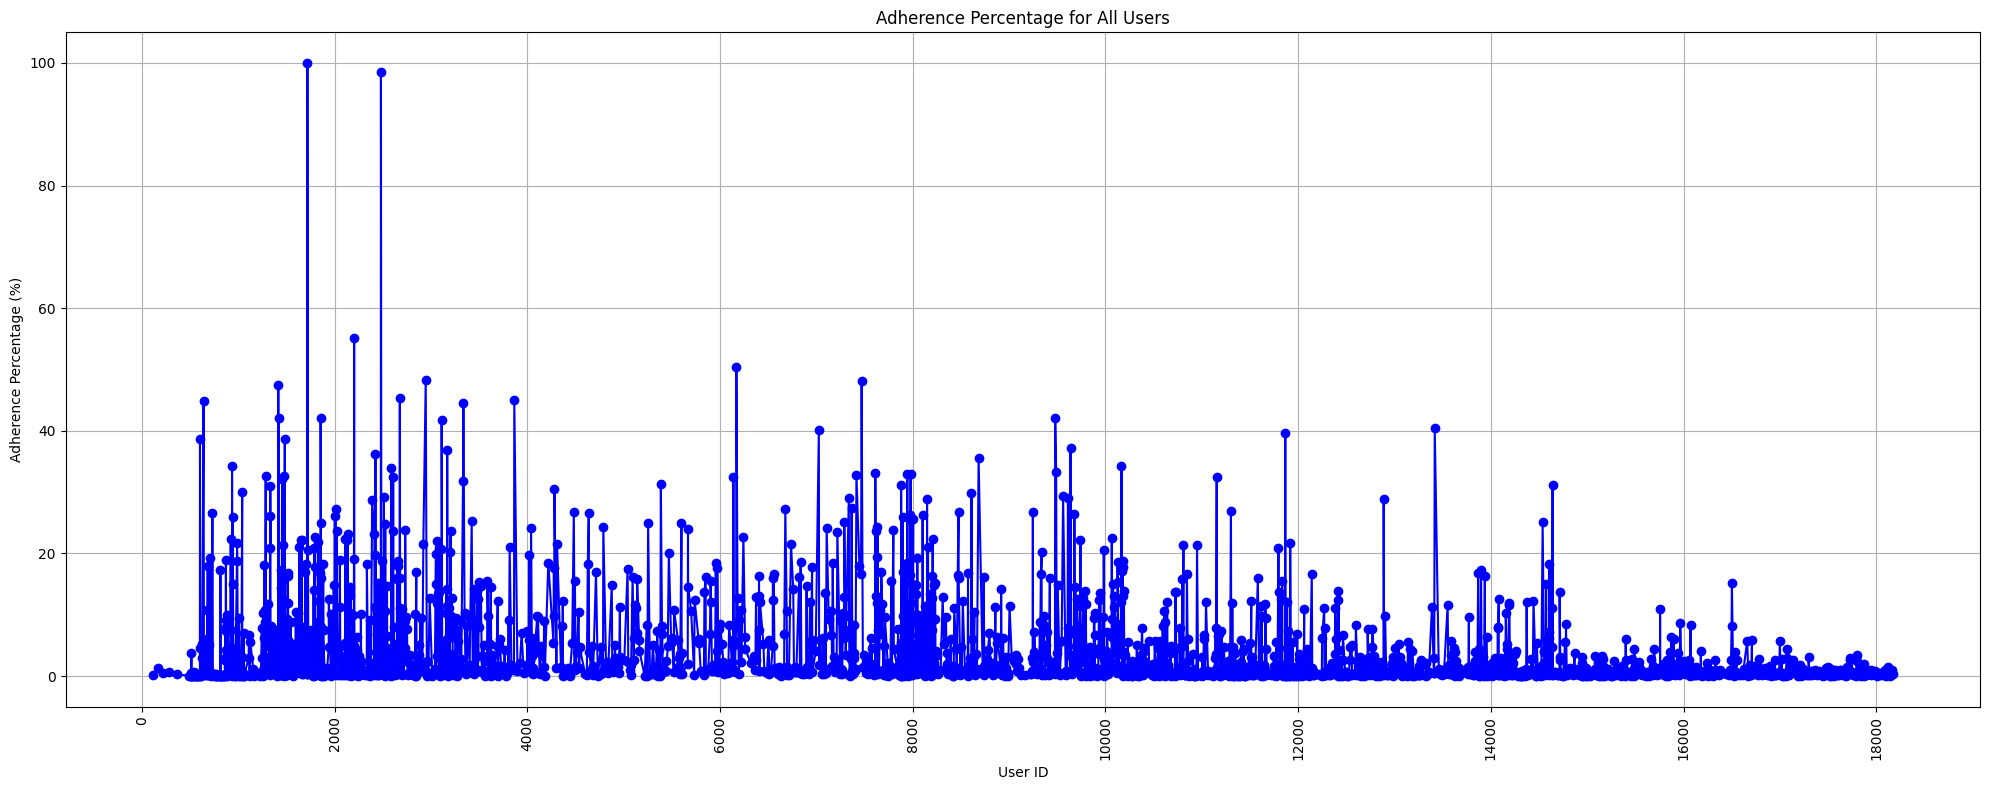

Top 10 users with higher adherence based on GRU Model Predictions:
     user_id  Adherence_Score Adherence_Level  Adherence_Percentage
274     1718         1.000000     Exceptional            100.000000
450     2481         0.984941     Exceptional             98.494080
390     2203         0.552102            High             55.210178
874     6170         0.503460            High             50.346040
555     2946         0.483362        Moderate             48.336195
991     7470         0.480661        Moderate             48.066116
186     1416         0.474301        Moderate             47.430077
514     2677         0.453565        Moderate             45.356539
692     3865         0.450849        Moderate             45.084884
34       640         0.449282        Moderate             44.928238


In [317]:
# Primero, volvamos a escalar todos los datos utilizando el mismo scaler que usamos para el entrenamiento
scaled_features_all = scaler.transform(features_train)  # Utilizando el scaler ajustado en los datos de entrenamiento

# Calcular las puntuaciones de adherencia para todo el dataset
min_time = scaled_features_all[:, 1].min()
max_time = scaled_features_all[:, 1].max()

adherence_scores_all = (scaled_features_all[:, 1] - min_time) / (max_time - min_time)  # Normalizando la adherencia

# Crear niveles de adherencia basados en los umbrales definidos
thresholds = np.linspace(0, 1, 7)  # 6 niveles de adherencia

adherence_levels_all = []

for score in adherence_scores_all:
    if score <= thresholds[1]:
        adherence_levels_all.append('Very Low')
    elif score <= thresholds[2]:
        adherence_levels_all.append('Low')
    elif score <= thresholds[3]:
        adherence_levels_all.append('Moderate')
    elif score <= thresholds[4]:
        adherence_levels_all.append('High')
    elif score <= thresholds[5]:
        adherence_levels_all.append('Very High')
    else:
        adherence_levels_all.append('Exceptional')

# Crear el DataFrame de adherencia
adherence_df_all = pd.DataFrame({
    'user_id': user_ids_train,
    'Adherence_Score': adherence_scores_all,
    'Adherence_Level': adherence_levels_all
})

# Contar el número de usuarios en cada nivel de adherencia
adherence_distribution_all = adherence_df_all['Adherence_Level'].value_counts()
print(adherence_distribution_all)

# Visualizar la distribución de niveles de adherencia
plt.figure(figsize=(10, 6))
sns.countplot(x='Adherence_Level', data=adherence_df_all, order=['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Exceptional'])
plt.title('Distribution of Adherence Levels for All Users')
plt.xlabel('Adherence Level')
plt.ylabel('Number of Users')
plt.show()

# Convertir las puntuaciones de adherencia a porcentajes
adherence_df_all['Adherence_Percentage'] = adherence_df_all['Adherence_Score'] * 100

# Ordenar el DataFrame por user_id
adherence_df_all = adherence_df_all.sort_values(by='user_id')

# Graficar el porcentaje de adherencia por usuario
plt.figure(figsize=(20, 8))
plt.plot(adherence_df_all['user_id'], adherence_df_all['Adherence_Percentage'], marker='o', linestyle='-', color='b')
plt.title('Adherence Percentage for All Users')
plt.xlabel('User ID')
plt.ylabel('Adherence Percentage (%)')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x si hay muchos usuarios
plt.grid(True)

# Opcional: limitar el número de ticks en el eje x si el gráfico está muy cargado
plt.locator_params(axis='x', nbins=10)  # Ajustar el número de ticks en el eje x

plt.tight_layout()
plt.show()

# Mostrar una tabla con los 10 usuarios con mayor adherencia
top_adherence_users_gru = adherence_df_all.sort_values(by='Adherence_Percentage', ascending=False).head(10)
print("Top 10 users with higher adherence based on GRU Model Predictions:")
print(top_adherence_users_gru)

In [318]:
# Verifica los primeros 10 IDs en top_adherence_users
print("User IDs en top_adherence_users:")
print(top_adherence_users_gru['user_id'].values)

# Verifica si estos IDs están presentes en df_filtered_merged
print("Coincidencia de IDs en df_filtered_merged:")
print(df_filtered_merged['user_programs_user_id'].isin(top_adherence_users_gru['user_id']).sum())

# Filtra df_filtered_merged para obtener solo las filas que coinciden con los IDs en top_adherence_users
filtered_df = df_filtered_merged[df_filtered_merged['user_programs_user_id'].isin(top_adherence_users_gru['user_id'])]

# Verifica si hay datos después de filtrar
print("Número de filas en filtered_df después del filtrado:", len(filtered_df))

# Si hay filas coincidentes, procede con el merge
if len(filtered_df) > 0:
    selected_columns = filtered_df[['user_programs_user_id', 'sum_of_reps', 'sum_of_time', 'total_count_of_series_reps', 
                                    'total_count_of_series_time', 'total_training_days']]

    # Agrupar por 'user_programs_user_id' para sumar las columnas específicas
    selected_columns = selected_columns.groupby('user_programs_user_id').agg({
        'sum_of_reps': 'sum',
        'sum_of_time': 'sum',
        'total_count_of_series_reps': 'sum',
        'total_count_of_series_time': 'sum',
        'total_training_days': 'first'  # Mantén el primer valor para esta columna
    }).reset_index()

    # Renombra columnas en selected_columns para evitar conflictos durante el merge
    selected_columns = selected_columns.rename(columns={
        'sum_of_reps': 'sum_of_reps_merged',
        'sum_of_time': 'sum_of_time_merged',
        'total_count_of_series_reps': 'total_count_of_series_reps_merged',
        'total_count_of_series_time': 'total_count_of_series_time_merged',
        'total_training_days': 'total_training_days_merged'
    })

    # Elimina la columna 'user_programs_user_id' duplicada antes del merge
    top_adherence_users_gru = top_adherence_users_gru.drop(columns=['user_programs_user_id'], errors='ignore')

    # Realiza el merge con top_adherence_users usando 'user_id' y 'user_programs_user_id'
    merged_df = pd.merge(top_adherence_users_gru, selected_columns, 
                         left_on='user_id', right_on='user_programs_user_id', 
                         how='left')

    # Selecciona y reorganiza las columnas que deseas mostrar
    final_df_gru = merged_df[['user_id', 'Adherence_Score', 'Adherence_Level', 'Adherence_Percentage',
                          'sum_of_reps_merged', 'sum_of_time_merged', 'total_count_of_series_reps_merged', 
                          'total_count_of_series_time_merged', 'total_training_days_merged']]

    # Muestra la tabla resultante
    print("Top 10 users with higher adherence and their training details:")
    print(final_df_gru.head())
else:
    print("No hay coincidencias entre los IDs de top_adherence_users y df_filtered_merged.")


User IDs en top_adherence_users:
[1718 2481 2203 6170 2946 7470 1416 2677 3865  640]
Coincidencia de IDs en df_filtered_merged:
1469
Número de filas en filtered_df después del filtrado: 1469
Top 10 users with higher adherence and their training details:
   user_id  Adherence_Score Adherence_Level  Adherence_Percentage  \
0     1718         1.000000     Exceptional            100.000000   
1     2481         0.984941     Exceptional             98.494080   
2     2203         0.552102            High             55.210178   
3     6170         0.503460            High             50.346040   
4     2946         0.483362        Moderate             48.336195   

   sum_of_reps_merged  sum_of_time_merged  total_count_of_series_reps_merged  \
0            118723.0            444322.0                              10309   
1             95980.0            437631.0                               6601   
2             54391.0            245315.0                               5064   
3          

In [320]:
final_df_gru

,user_id,Adherence_Score,Adherence_Level,Adherence_Percentage,sum_of_reps_merged,sum_of_time_merged,total_count_of_series_reps_merged,total_count_of_series_time_merged,total_training_days_merged
0,1718,1.000000,Exceptional,100.000000,118723.0,444322.0,10309,15482,208
1,2481,0.984941,Exceptional,98.494080,95980.0,437631.0,6601,9676,173
2,2203,0.552102,High,55.210178,54391.0,245315.0,5064,7772,141
3,6170,0.503460,High,50.346040,51462.0,223703.0,4310,5835,143
4,2946,0.483362,Moderate,48.336195,42479.0,214773.0,3868,5371,116
5,7470,0.480661,Moderate,48.066116,36082.0,213573.0,3054,4677,137
6,1416,0.474301,Moderate,47.430077,44922.0,210747.0,4120,6357,118
7,2677,0.453565,Moderate,45.356539,53986.0,201534.0,4835,7782,182
8,3865,0.450849,Moderate,45.084884,36207.0,200327.0,2972,4584,118
9,640,0.449282,Moderate,44.928238,61194.0,199631.0,4322,6055,133
